In [1]:
import numpy as np
import scipy.integrate as si
import matplotlib.pyplot as plt

In [2]:
def r2(s,x,y,z):
    xy = x**2 + y**2
    Rp2 = xy + (z-s)**2
    Rm2 = xy + (z+s)**2
    return Rp2, Rm2

def dU_dx(asq, Mp,Mm,U,Rp,Rm, x):
    T1 = (Mp * x) / Rp**(3/2)
    T2 = (Mm * x) / Rm**(3/2)
     
    return 2 * U**((1-asq) / (1 + asq)) * (T1 + T2)

def dU_dy(asq, Mp,Mm,U,Rp,Rm,y):
    T1 = (Mp * y) / (Rp**3)
    T2 = (Mm * y) / (Rm**3)
    return 2 * U**((1-asq) / (1 + asq)) * (T1 + T2)

def dU_dz(asq, Mp,Mm,U,s,Rp,Rm,z):
    T1 = Mp * (z-s) / Rp**(3/2)
    T2 = Mm * (z+s) / Rm**(3/2)
    return 2 * U**((1-asq) / (1 + asq)) * (T1 + T2)

In [3]:
def harmU(asq,Mp,Mm,rp,rm):
    T1 = Mp/np.sqrt(rp)
    T2 = Mm/np.sqrt(rm)
    return 1 + (1 + asq)*(T1 + T2)

In [16]:
def dYdt_planar(Mp,Mm,asq,s,xp):
    x,z,px,pz = xp
    
    #Distance from each center
    rp, rm = r2(s,x,0,z)
    
    U = harmU(asq,Mp,Mm,rp,rm)
    U2 = U**(2/(1+asq))
    # These are the derivatives of U^2 w.r.t. x and z
    Ux = dU_dx(asq,Mp,Mm,U,rp,rm,x)
    Uz = dU_dz(asq,Mp,Mm,U,s,rp,rm,z)

    #\dot{x} = U^{-2} px
    #\dot{px} = \pdv{U^2}{x} * pt (set to -1)
    return np.array([px/U2, pz/U2, -Ux, -Uz])

In [17]:
def initial_planar(M,asq,s,alpha):
    x0, z0 = 0., 0.
    U0 = 1 + 2*((M*(1 + asq))/s)
    U02 = U0**(2/(1+asq))
    px0 = U02 * np.cos(alpha)
    pz0 = U02 * np.sin(alpha)
    return (x0, z0, px0, pz0)

In [18]:
def lightlike(asq,s,Mp,Mm,q):
    x,z,px,pz = q
    rp,rm = r2(s,x,0,z)
    U = harmU(asq,Mp,Mm,rp,rm)
    U2 = U**(2/(1 + asq))
    # Metric is defined by
    # -U2/(1+a^2) pt^2 + 1/(U^2/(1+a^2)) pi^2
    # with pt = -1
    return (1/U2)*(px**2 + pz**2) - U2;


In [19]:
def integrate_planar(M,asq,s,alpha,t_span,y0):
    # Remember the convention Y = [x z px pz]
    field = lambda t,y: dYdt_planar(M,M,asq,s,y)
    sol = si.solve_ivp(field, t_span, y0, method="BDF") #, atol=1e-10, rtol=1e-6)
    return sol

In [20]:
def symbolic_code(sol):
    x = sol.y[0]
    z = sol.y[1]
    code = []
    for i in range(len(x)-1):
        # if this product is negative
        # then we have crossed the z-axis
        if x[i+1] * x[i] < 0:
            mid = (z[i] + z[i+1])/2
            if mid > 1:
                code.append(1)
            elif mid < -1:
                code.append(-1)
            else:
                code.append(0)
    return code

In [21]:
def run_simulation(M=1., s=1., asq=0., 
                   N=50, t_end=100, alphaMin=0.44, alphaMax=0.51, 
                   truncate=True, bounds=True):

    #settings for numerical integration
    # N = 200              #Number of trajectories that are generated
    # t_end = 100          #Check what the characteristic scale should be (~20 seems stable)
    t_span = [0, t_end]
    ETol = 1             #If E>ETol, then disregard, because it's not physical
    # alphaMin = 0.44      #Without dilaton any alpha < 0.44 is boring
    # alphaMax = 0.51      #and so is any alpha > 0.51
    alphas = np.linspace(alphaMin,alphaMax,N);
    classes = np.zeros(N)
    codes = []

    plt.figure(figsize=(10,10))
    plt.title("Evolution of lightlike trajectories")
    
    for (j, alpha) in enumerate(alphas):
        #initial conditions [x0, z0, px0, pz0]
        y0 = initial_planar(M,asq,s,alpha)

        #Perform numerical integration, YOUT(x,z,px,pz)
        sol = integrate_planar(M,asq,s,alpha,t_span, y0)
        #[XAr,YAr,ZAr] = bagel_plot(YOUT,s,M,M,Rmax)

        #Compute the energy of the trajectory and throw away deviants
        if truncate:
            st = sol.y.T
            for i in range(len(sol.t)):
                E = lightlike(asq,s,M,M,st[i])
                if np.abs(E) > ETol:
                    # print(i/len(sol.t))
                    break

            soly = np.array([sol.y[0][:i-1],sol.y[1][:i-1]])
        else:
            soly = sol.y

        #Classify and plot
        #the trajectory (all) and an x at the error reached
        rp,rm = r2(s,soly[0][-1],0,soly[1][-1]);
        if rp < 0.5:
            classes[j] = 1
            color="green"
        elif rm < 0.5:
            classes[j] = -1
            color="lightblue"
        else:
            color="orange"
            # it is already 0
            # classes[j] = 0

        plt.plot(soly[0], soly[1], linewidth=0.5, color=color)
        
        if truncate:
            plt.scatter(soly[0][-1],soly[1][-1],marker='x',color=color)

        #Give the corresponding symbolic code (CG conventions)
        code = symbolic_code(sol)
        codes.append(code)

    if bounds:
        plt.xlim(-5,5)
        plt.ylim(-5,5)
    plt.scatter(0,s,s=10,color="r")
    plt.scatter(0,-s,s=10,color="r")
    ax = plt.gcf().gca()
    cc = plt.Circle(( 0 , s ), 0.5, color="r", fill=False )
    ax.add_patch(cc)
    cc = plt.Circle(( 0 , -s ), 0.5, color="r", fill=False )
    ax.add_patch(cc)
    # cc = plt.Circle(( 0 , 0 ), 2, color="b", fill=False )
    # ax.add_patch(cc)
    plt.show()

    #Plot of classification versus initial angle
    plt.figure(figsize=(10,2))
    plt.title("Ray termination in function of the angle")
    plt.scatter(alphas,classes,s=1)
    plt.show()

    #Plot code lengths
    lens = [len(v) for v in codes]
    sup = max(lens)+1
    bcounts = np.bincount(lens)
    fig = plt.figure()
    plt.title("Length statistics of codings")
    ax = plt.gca()
    ax.bar(range(sup), bcounts, width=1, align='center')
    ax.set(xticks=range(sup), xlim=[-1, sup])
    plt.show()
    
    return alphas, classes, codes

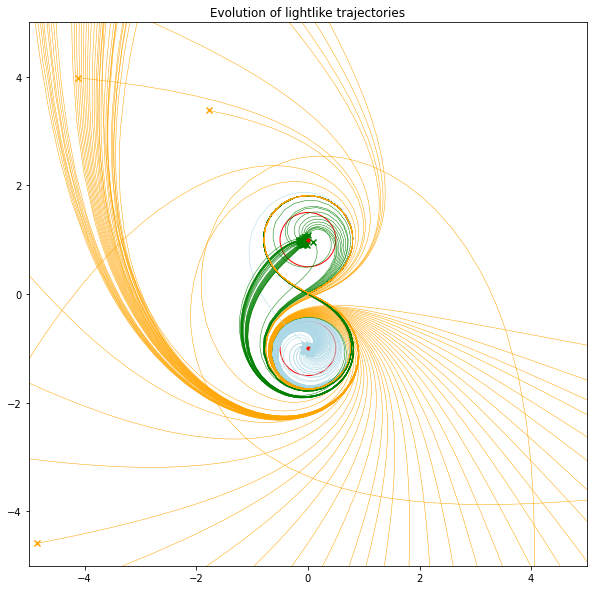

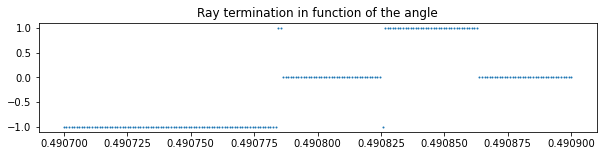

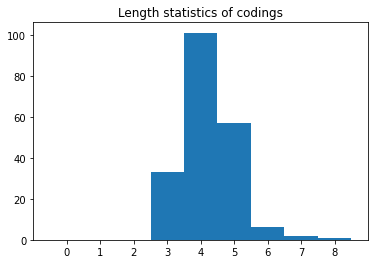

In [22]:
_ = run_simulation(M=1., s=1., asq=0.,
                   alphaMin=.4907, alphaMax=.4909,
                   N=200)

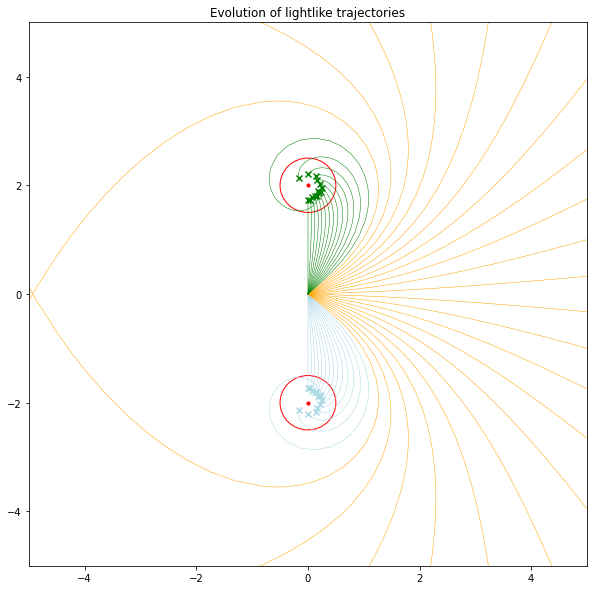

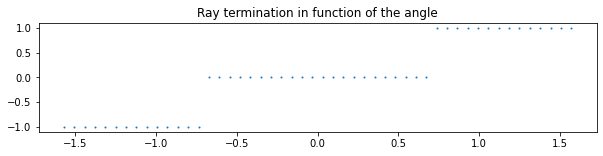

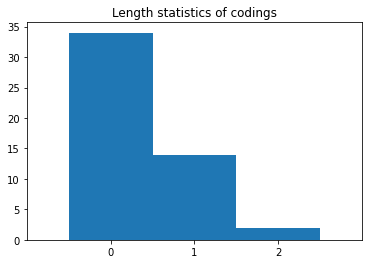

In [23]:
_ = run_simulation(
    M=1, s=2, asq=0.01,
    alphaMin=-1.57, alphaMax=1.57, N=50,
    truncate=True, bounds=True)

In [ ]:
_ = run_simulation(
    M=1, s=2, asq=1,
    alphaMin=-1.57, alphaMax=1.57, N=50,
    truncate=False, bounds=False)

In [ ]:
_ = run_simulation(
    M=1, s=2, asq=3,
    alphaMin=-1.57, alphaMax=1.57, N=50,
    truncate=False, bounds=False)